In [1]:
import glob

root = glob.glob('./img/*')
print(root)

['./img\\1', './img\\10', './img\\2', './img\\3', './img\\4', './img\\5', './img\\6', './img\\7', './img\\8', './img\\9']


In [2]:
import cv2
import numpy as np
from tqdm import tqdm

image = []
label = []

task = tqdm(root)

for img_dir in task:
    img_path = (img_dir.replace('\\', '/'))
    img_path = glob.glob(img_path + '/*')

    for images in img_path:
        img = cv2.imread(images, 1)
        img = np.transpose(img, (2, 0, 1))
        image.append(img / 255)

        label.append(int((((images.split('/'))[2]).split('\\'))[0]) - 1)

image = np.array(image)
label = np.array(label)

print(image.shape, label.shape)

100%|██████████| 10/10 [00:02<00:00,  3.83it/s]
(5000, 3, 96, 96)(5000,)


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [4]:
x_train = torch.FloatTensor(image)
y_train = torch.FloatTensor(label)

In [5]:
dataset = TensorDataset(x_train, y_train)
train_set, val_set = torch.utils.data.random_split(dataset, [4500, 500])

In [6]:
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True)

In [7]:
classes = ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']

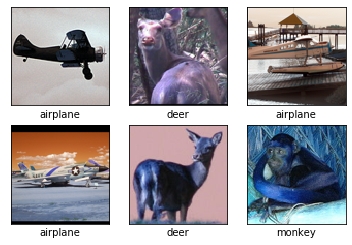

In [9]:
import matplotlib.pyplot as plt

dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()
labels = labels.numpy()

fig = plt.figure()
rows = 2
cols = 3

for i, image in enumerate(images):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.imshow(np.transpose(image, (1, 2, 0)))
    ax.set_xlabel(classes[int(labels[i])])
    ax.set_xticks([]), ax.set_yticks([])
    i += 1
    
    if i >= rows * cols:
        break

In [10]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        self.avg_pool = nn.AvgPool2d(12)
        self.classifier = nn.Linear(256, 10)
        

    def forward(self, x):
        x = self.layer1(x)
        # torch.Size([32, 32, 48, 48])
        x = self.layer2(x)
        # torch.Size([32, 32, 24, 24])
        features = self.layer3(x)
        # torch.Size([32, 32, 12, 12])

        x = self.avg_pool(features)
        # torch.Size([32, 64, 1, 1])
        flatten = x.view(features.size(0), -1)
        # torch.Size([32, 64])

        output = self.classifier(flatten)

        return output, features

net = CNN()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net.to(device)

cuda:0


CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avg_pool): AvgPool2d(kernel_size=12, stride=12, padding=0)
  (classifier): Linear(in_features=256, out_fea

In [13]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=5)

In [14]:
train_losses, val_losses, accuracy = [], [], []
epochs = 35

for epoch in range(epochs):
    running_loss = 0
    
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        labels = labels.long()

        optimizer.zero_grad()

        outputs, features = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    else:
        val_loss = 0
        val_accuracy = 0
        acc = 0
        
        with torch.no_grad():
            for val_image, val_label in val_loader:
                val_image, val_label = val_image.to(device), val_label.to(device)
                val_label = val_label.long()
                
                val_outputs, features = net(val_image)
                _, top_class = val_outputs.topk(1, dim=1)
                pred = top_class.cpu().numpy()
                batch, _ = pred.shape
                target = (val_label.cpu().numpy()).reshape(batch, 1)
                
                correct = np.sum(pred == target)
                acc += correct / batch
                
                val_loss += criterion(val_outputs, val_label)

        acc = acc / len(val_loader)
        
        train_losses.append(running_loss/len(train_loader))
        val_losses.append(val_loss/len(val_loader))
        accuracy.append(acc)

        lr_scheduler.step(val_loss/len(val_loader))

        print("Epoch: {}/{} || ".format(epoch+1, epochs),
              "Training Loss: {:.5f} || ".format(running_loss/len(train_loader)),
              "Val Loss: {:.5f} || ".format(val_loss/len(val_loader)),
              "Val ACC : {:.5f}".format(acc)
             )

print('Finished Training')

Epoch: 1/35 ||Training Loss: 1.96200 ||Val Loss: 1.92474 ||Val ACC : 0.19531
Epoch: 2/35 ||Training Loss: 1.75199 ||Val Loss: 1.64452 ||Val ACC : 0.33047
Epoch: 3/35 ||Training Loss: 1.67144 ||Val Loss: 1.69507 ||Val ACC : 0.33672
Epoch: 4/35 ||Training Loss: 1.66062 ||Val Loss: 1.60583 ||Val ACC : 0.35859
Epoch: 5/35 ||Training Loss: 1.60570 ||Val Loss: 1.58459 ||Val ACC : 0.36680
Epoch: 6/35 ||Training Loss: 1.56708 ||Val Loss: 1.51234 ||Val ACC : 0.38633
Epoch: 7/35 ||Training Loss: 1.53084 ||Val Loss: 1.49855 ||Val ACC : 0.40078
Epoch: 8/35 ||Training Loss: 1.50104 ||Val Loss: 1.53990 ||Val ACC : 0.36797
Epoch: 9/35 ||Training Loss: 1.46943 ||Val Loss: 1.50145 ||Val ACC : 0.42148
Epoch: 10/35 ||Training Loss: 1.44248 ||Val Loss: 1.47258 ||Val ACC : 0.41602
Epoch: 11/35 ||Training Loss: 1.43463 ||Val Loss: 1.48578 ||Val ACC : 0.42578
Epoch: 12/35 ||Training Loss: 1.38611 ||Val Loss: 1.39673 ||Val ACC : 0.46133
Epoch: 13/35 ||Training Loss: 1.36145 ||Val Loss: 1.37155 ||Val ACC : 0.4

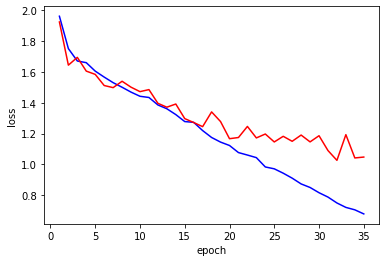

In [15]:
x = np.arange(1, 36, 1)

plt.plot(x, train_losses,'b', label='train loss')
plt.plot(x, val_losses,'r', label='val loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

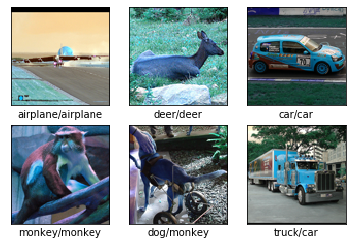

In [22]:
dataiter = iter(val_loader)
inputs, labels = dataiter.next()
images = inputs.numpy()
labels = labels.numpy()

outputs, _ = net(inputs.to(device))
outputs.cpu().detach().numpy()
_, outputs = outputs.topk(1, dim=1)

fig = plt.figure()
rows = 2
cols = 3

for i, image in enumerate(images):
    ax = fig.add_subplot(rows, cols, i + 1)
    image = np.transpose(image, (1, 2, 0))
    ax.imshow(image)
    ax.set_xlabel(classes[int(labels[i])] + '/' + classes[int(outputs[i])])
    ax.set_xticks([]), ax.set_yticks([])
    i += 1
    
    if i >= rows * cols:
        break

In [54]:
params = list(net.parameters())
# get weight only from the last layer(linear)
weight_softmax = np.squeeze(params[-2].cpu().data.numpy())
print(weight_softmax.shape)

(10, 256)


horse/deer


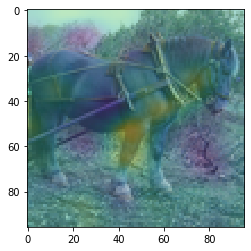

airplane/airplane


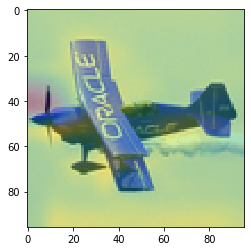

car/car


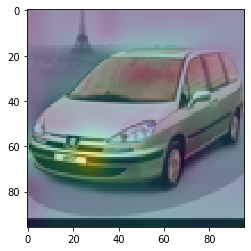

truck/airplane


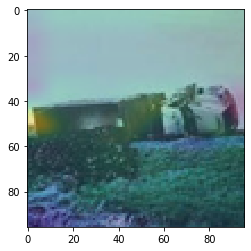

horse/deer


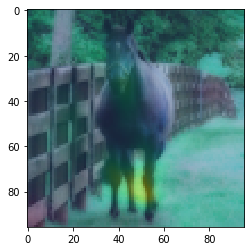

cat/cat


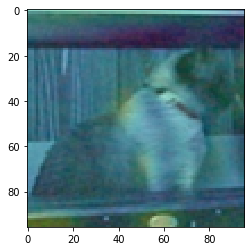

airplane/airplane


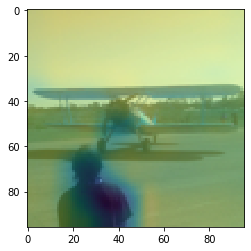

cat/cat


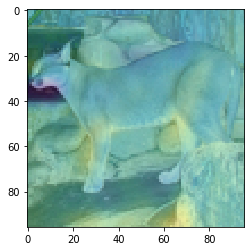

monkey/monkey


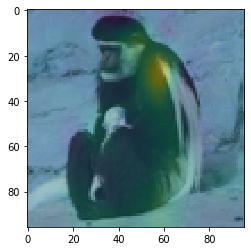

deer/deer


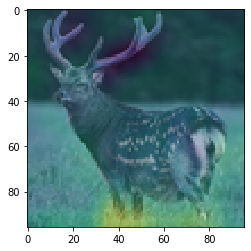

dog/monkey


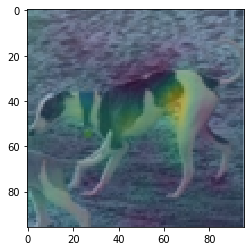

deer/monkey


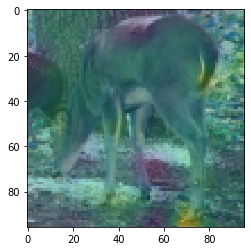

truck/airplane


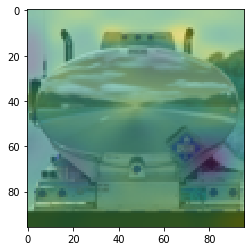

car/car


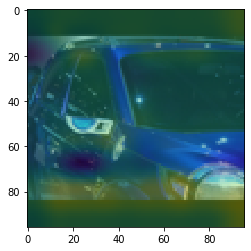

cat/airplane


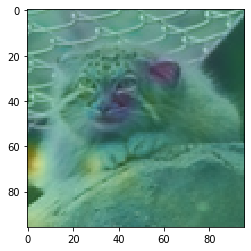

deer/deer


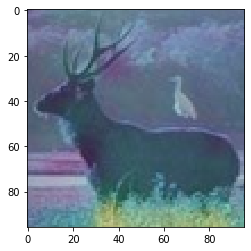

monkey/monkey


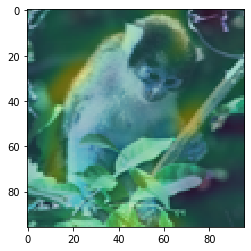

monkey/monkey


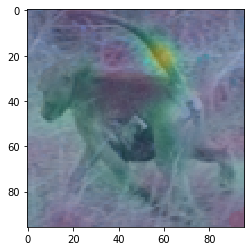

car/car


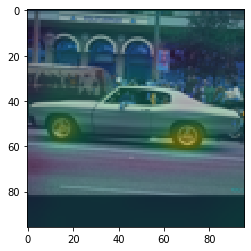

dog/dog


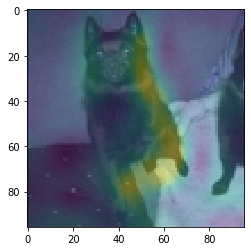

bird/bird


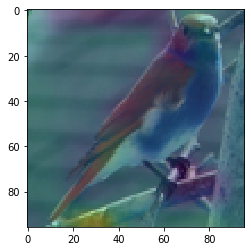

dog/monkey


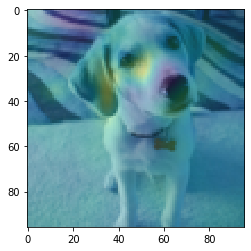

dog/dog


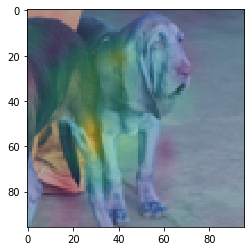

horse/bird


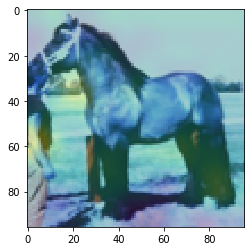

airplane/airplane


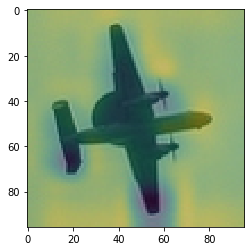

cat/deer


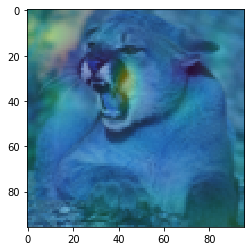

dog/monkey


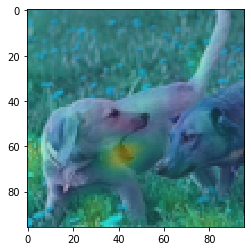

bird/bird


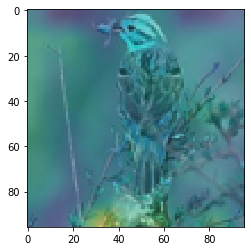

cat/cat


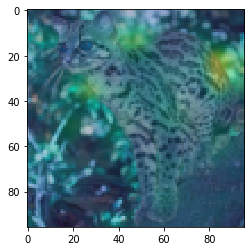

monkey/monkey


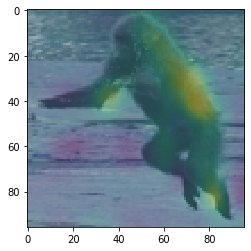

deer/monkey


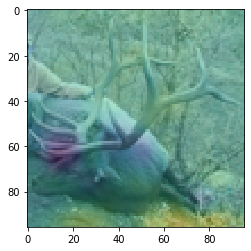

horse/dog


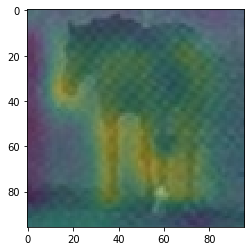

In [71]:
import cv2

dataiter = iter(val_loader)
inputs, labels = dataiter.next()
images = inputs.numpy()
labels = labels.numpy()

outputs, features = net(inputs.to(device))
outputs.cpu().detach().numpy()
_, outputs = outputs.topk(1, dim=1)

for c, feature_map in enumerate(features):

    original = images[c]
    label = labels[c]

    original = np.transpose(original, (1, 2, 0))
    feature_map = feature_map.cpu().detach().numpy()

    CAM = np.zeros(((feature_map.shape)[1], (feature_map.shape)[2]))

    for i in range((feature_map.shape)[0]):
        CAM = CAM + feature_map[i] * (weight_softmax[int(label)])[i]
    
    CAM = cv2.resize(CAM, (96, 96), interpolation=cv2.INTER_CUBIC)
    plt.imshow(original, interpolation='none')
    plt.imshow(CAM, interpolation='none', alpha=0.4)
    print(classes[int(label)] + '/' + classes[int(outputs[c])])
    plt.show()